In [28]:
from __future__ import annotations

import math
from typing import List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# ------------------------- 1. Data utilities ---------------------------------

class AllHistoryDataset(Dataset):
    """Sliding window dataset producing (Xpast, Yfuture) pairs.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame of shape (T, 4*m) with ordered columns:
        [stock1_Open, stock1_High, stock1_Low, stock1_Close, stock2_Open, ...].
    tickers : List[str]
        Ticker symbols in the same order as blocks in *df* columns.
    tau : int, default 63
        Window length in trading days (~1 quarter).
    stride : int, default 1
        Stride between consecutive samples (can be set to tau for non-overlap).
    """

    def __init__(self, df: pd.DataFrame, tickers: List[str], tau: int = 63, stride: int = 1):
        super().__init__()
        self.df = df.copy(); self.tau = tau; self.stride = stride
        self.tickers = tickers; self.m = len(tickers)
        # column order check --------------------------------------------------
        cols_exp = []
        for tk in tickers:
            cols_exp.extend([f"{tk}_open", f"{tk}_close", f"{tk}_high", f"{tk}_low"])
        if list(df.columns) != cols_exp:
            raise ValueError("Column order must be Open,Close,High,Low per ticker.")
        # Close‑to‑Close returns ---------------------------------------------
        close = df[[f"{tk}_close" for tk in tickers]].values
        returns = (np.roll(close, -1, axis=0) - close) / close
        returns[-1, :] = np.nan
        self.returns = returns
        T = len(df)
        self.ends = [t for t in range(tau, T - tau) if (t - tau) % stride == 0]

    def __len__(self):
        return len(self.ends)

    def __getitem__(self, idx):
        end_t = self.ends[idx]
        past = self.df.iloc[:end_t].values.reshape(-1, self.m, 4).astype(np.float32)
        fut = self.returns[end_t: end_t + self.tau].astype(np.float32)
        return torch.from_numpy(past), torch.from_numpy(fut)



In [29]:
class PositionalEncoding(nn.Module):
    """Standard sine-cosine positional encoding (used for each time step)."""

    def __init__(self, d_model: int, max_len: int = 50000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)  # (max_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Add PE to input x (time, batch, dim)."""
        seq_len = x.size(0)
        return x + self.pe[:seq_len].unsqueeze(1)
    


def make_transformer_encoder(d_model: int, n_heads: int, n_layers: int, dropout: float = 0.1):
    enc_layer = nn.TransformerEncoderLayer(d_model, n_heads, dim_feedforward=4*d_model, dropout=dropout, batch_first=False)
    return nn.TransformerEncoder(enc_layer, n_layers)


class Encoder(nn.Module):
    """Encoder with *Stock ID* + *Quarter ID* embeddings."""

    def __init__(self, m: int, tau: int, d_model: int = 128, latent_dim: int = 32, n_heads: int = 4, n_layers: int = 2):
        super().__init__()
        self.m = m
        self.tau = tau
        self.d_stock = d_model // 8
        self.d_quarter = d_model // 8
        self.stock_embed = nn.Embedding(m, self.d_stock)
        self.quarter_embed = nn.Embedding(1024, self.d_quarter)  # up to 1024 quarters
        self.input_fc = nn.Linear(4 + self.d_stock + self.d_quarter, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.transformer = make_transformer_encoder(d_model, n_heads, n_layers)
        self.mu_head = nn.Linear(d_model, latent_dim)
        self.logvar_head = nn.Linear(d_model, latent_dim)

    def forward(self, past: torch.Tensor):
        """Parameters
        ----------
        past : Tensor (L, m, 4) with O,C,H,L.
        Returns
        -------
        mu, logvar  : (batch=1, d_model)
        """
        L, m, _ = past.shape
        assert m == self.m
        device = past.device

        # ---- build embeddings ------------------------------------------------
        stock_ids = torch.arange(m, device=device)
        stock_emb = self.stock_embed(stock_ids)  # (m, d_stock)
        stock_emb = stock_emb.unsqueeze(0).expand(L, -1, -1)  # (L, m, d_stock)

        quarter_ids = torch.arange(L, device=device) // self.tau  # (L,)
        q_emb = self.quarter_embed(quarter_ids)  # (L, d_quarter)
        q_emb = q_emb.unsqueeze(1).expand(-1, m, -1)

        x = torch.cat([past, stock_emb, q_emb], dim=-1)  # (L, m, 4 + d_s + d_q)
        x = self.input_fc(x)  # (L, m, d_model)

        # Flatten (time*stock) as sequence tokens
        x = x.reshape(L * m, -1).unsqueeze(1)  # (seq, batch=1, d_model)
        x = self.pos_enc(x)
        h = self.transformer(x)  # (seq, 1, d_model)
        h = h.mean(dim=0)  # global average → (1, d_model)
        mu = self.mu_head(h)
        logvar = self.logvar_head(h)
        return mu.squeeze(0), logvar.squeeze(0)



In [30]:
class Decoder(nn.Module):
    def __init__(self, m: int, d_latent: int, n_bins: int = 21):
        super().__init__()
        self.m = m
        self.n_bins = n_bins
        self.mlp = nn.Sequential(
            nn.Linear(d_latent, 2 * d_latent), nn.ReLU(),
            nn.Linear(2 * d_latent, m * n_bins)
        )

    def forward(self, z: torch.Tensor):
        logits = self.mlp(z)
        return logits.view(-1, self.m, self.n_bins)

class VAE(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super().__init__(); self.encoder = encoder; self.decoder = decoder

    def forward(self, past: torch.Tensor):
        # 编码阶段 ------------------------------------------------------------
        mu, logvar = self.encoder(past)                  # (latent_dim,)
        # ⭐ re‑parameterization 仍留在 VAE 层：这样 Encoder 纯粹输出参数，
        #   既方便 Teacher‑Student 阶段对齐，也保持计算图正确流动。
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        logits = self.decoder(z.unsqueeze(0))            # (1, m, n_bins)
        return logits, mu, logvar
    
# --------------------------- 4. Loss helpers ---------------------------------

def elbo_loss(logits, y_future, mu, logvar, n_bins, beta=0.2):
    """ELBO = recon + β·KL
    * logits : (1,m,n_bins)
    * y_future : (τ,m)  — may contain NaNs at tail, we ignore those rows
    """
    m = logits.size(1)
    edges = torch.linspace(-0.2, 0.2, n_bins + 1, device=logits.device)
    bin_w = edges[1] - edges[0]
    target = []
    for j in range(m):
        r_j = y_future[:, j]
        mask = torch.isfinite(r_j)
        r = r_j[mask].clamp(edges[0], edges[-2] + 1e-6)  # ensure inside range
        # Convert return → bin idx 0..n_bins-1
        idx = ((r - edges[0]) / bin_w).floor().long().clamp(0, n_bins - 1)
        onehot = F.one_hot(idx, n_bins).float().mean(0)
        target.append(onehot)
    target = torch.stack(target)                 # (m,n_bins)
    recon = F.cross_entropy(logits.squeeze(0), target, reduction="sum") / m
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl

In [31]:
# ----------------------- 5. Trainer ------------------------------------------

class BRAVETrainer:
    def __init__(self, tickers: List[str], tau: int = 63, model_dim: int = 128, latent_dim: int = 64,
                 n_bins: int = 21, device: str = "cpu"):
        self.m = len(tickers); self.tau = tau; self.device = device; self.n_bins = n_bins
        self.decoder = Decoder(self.m, latent_dim, n_bins).to(device)
        self.teacher_enc = Encoder(self.m, tau, model_dim, latent_dim).to(device)
        self.student_enc = Encoder(self.m, tau, model_dim, latent_dim).to(device)
        self.teacher_vae = VAE(self.teacher_enc, self.decoder)
        # Student 直接与 teacher_enc 输出对齐，而不是 full VAE
        self.mse = nn.MSELoss()

    # 教师阶段 ---------------------------------------------------------------
    def train_teacher(self, loader: DataLoader, epochs=5, lr=1e-4):
        opt = torch.optim.Adam(self.teacher_vae.parameters(), lr)
        for ep in range(epochs):
            tot = 0.
            for past, y in loader:
                past = past.squeeze(0).to(self.device)
                y    = y.squeeze(0).to(self.device)
                #print("Teacher Training: Finished loading data")
                logits, mu, logvar = self.teacher_vae(past)
                #print("Teacher Training: Finished forward pass")
                loss = elbo_loss(logits, y, mu, logvar, self.n_bins)
                #print("Teacher Training: Finished loss calculation")
                opt.zero_grad(); loss.backward(); opt.step(); tot += loss.item()
            print(f"Teacher-Epoch {ep+1}: {tot/len(loader):.4f}")

    # 学生阶段 ---------------------------------------------------------------
    def train_student(self, loader: DataLoader, epochs=5, lr=1e-4):
        self.decoder.eval(); self.teacher_enc.eval()
        for p in self.decoder.parameters(): p.requires_grad = False
        opt = torch.optim.Adam(self.student_enc.parameters(), lr)
        for ep in range(epochs):
            tot = 0.
            for past, _ in loader:
                past = past.squeeze(0).to(self.device)
                #print("Student Training: Finished loading data")
                with torch.no_grad():
                    mu_T, logvar_T = self.teacher_enc(past)
                    #print("Student Training: Finished teacher forward pass")
                mu_S, logvar_S = self.student_enc(past)
                #print("Student Training: Finished student forward pass")
                loss = self.mse(mu_S, mu_T) + self.mse(logvar_S, logvar_T)
                #print("Student Training: Finished loss calculation")
                opt.zero_grad(); loss.backward(); opt.step(); tot += loss.item()
            print(f"Student-Epoch {ep+1}: {tot/len(loader):.6f}")

    # 采样 -------------------------------------------------------------------
    @torch.no_grad()
    def sample_scenarios(self, past: torch.Tensor, N=1000):
        mu, logvar = self.student_enc(past.to(self.device))
        std = torch.exp(0.5 * logvar)
        edges = torch.linspace(-0.2, 0.2, self.n_bins + 1, device=self.device)
        arr = []
        for _ in range(N):
            z = mu + std * torch.randn_like(std)
            probs = self.decoder(z.unsqueeze(0)).softmax(-1).squeeze(0)  # (m, bins)
            idx = torch.multinomial(probs, 1).squeeze(1)
            lo, hi = edges[idx], edges[idx+1]
            arr.append(((hi-lo)*torch.rand_like(lo)+lo).cpu().numpy())
        return np.stack(arr)

In [32]:
data = pd.read_csv("combined_sp500_data.csv")
data.set_index("date", inplace=True)
data.index = pd.to_datetime(data.index)
data.index.name = None
data.head()

,A_open,A_close,A_high,A_low,A_vol,AAPL_open,AAPL_close,AAPL_high,AAPL_low,AAPL_vol,...,ZBRA_open,ZBRA_close,ZBRA_high,ZBRA_low,ZBRA_vol,ZTS_open,ZTS_close,ZTS_high,ZTS_low,ZTS_vol
2000-01-03 00:00:00+00:00,56.330471,43.463024,56.464592,48.193848,4674353,0.936384,0.844004,1.004464,0.907924,535796800,...,25.930555,25.027779,26.000000,24.777779,1055700,NaN,NaN,NaN,NaN,NaN
2000-01-04 00:00:00+00:00,48.730328,40.142937,49.266811,46.316166,4765083,0.966518,0.772846,0.987723,0.903460,512377600,...,25.027779,24.666668,25.166668,23.000000,522450,NaN,NaN,NaN,NaN,NaN
2000-01-05 00:00:00+00:00,47.389126,37.652866,47.567955,43.141991,5758642,0.926339,0.784155,0.987165,0.919643,778321600,...,23.569445,25.138889,25.222221,23.555555,612225,NaN,NaN,NaN,NaN,NaN
2000-01-06 00:00:00+00:00,44.080830,36.219177,44.349072,41.577251,2534434,0.947545,0.716296,0.955357,0.848214,767972800,...,24.819445,23.777779,24.819445,23.722221,263925,NaN,NaN,NaN,NaN,NaN
2000-01-07 00:00:00+00:00,42.247852,39.237446,47.165592,42.203148,2819626,0.861607,0.750226,0.901786,0.852679,460734400,...,23.666668,23.513889,24.055555,23.111111,333900,NaN,NaN,NaN,NaN,NaN


In [33]:
#取前20只股票（每只股票有5列数据），并去掉volume列
tickers = data.columns[::5][:4].tolist()
# Ticker为 "_"分隔的字符串
tickers = [tk.split("_")[0] for tk in tickers]
# 只保留前20只股票的开盘价、收盘价、最高价、最低价

#取前100列数据（即前20只股票的5列数据）
train_data = data.iloc[:, :100].copy()
train_data.head()
train_data = train_data[[f"{tk}_{col}" for tk in tickers for col in ["open", "close", "high", "low"]]]
train_data = train_data.dropna().astype(np.float32)
train_data.head()
train_data.shape

(955, 16)

Detected 4 tickers: ['A', 'AAPL', 'ABBV', 'ABNB']


/Users/hanjiaan/miniconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Teacher-Epoch 1: 3.1781
Teacher-Epoch 2: 2.6794
Teacher-Epoch 3: 2.4106
Teacher-Epoch 4: 2.1736
Teacher-Epoch 5: 1.9962
Teacher-Epoch 6: 1.8576
Teacher-Epoch 7: 1.7591
Teacher-Epoch 8: 1.6803
Teacher-Epoch 9: 1.6104
Teacher-Epoch 10: 1.5782
Teacher-Epoch 11: 1.5472
Teacher-Epoch 12: 1.5324
Teacher-Epoch 13: 1.4892
Teacher-Epoch 14: 1.4879
Teacher-Epoch 15: 1.4785
Teacher-Epoch 16: 1.4652
Teacher-Epoch 17: 1.4624
Teacher-Epoch 18: 1.4560
Teacher-Epoch 19: 1.4485
Teacher-Epoch 20: 1.4412
Teacher-Epoch 21: 1.4330
Teacher-Epoch 22: 1.4347
Teacher-Epoch 23: 1.4310
Teacher-Epoch 24: 1.4348
Teacher-Epoch 25: 1.4245
Teacher-Epoch 26: 1.4248
Teacher-Epoch 27: 1.4257
Teacher-Epoch 28: 1.4242
Teacher-Epoch 29: 1.4172
Teacher-Epoch 30: 1.4166
Student-Epoch 1: 0.048636
Student-Epoch 2: 0.000160
Student-Epoch 3: 0.000164
Student-Epoch 4: 0.000157
Student-Epoch 5: 0.000145
Student-Epoch 6: 0.000132
Student-Epoch 7: 0.000128
Student-Epoch 8: 0.000114
Student-Epoch 9: 0.000115
Student-Epoch 10: 0.00012

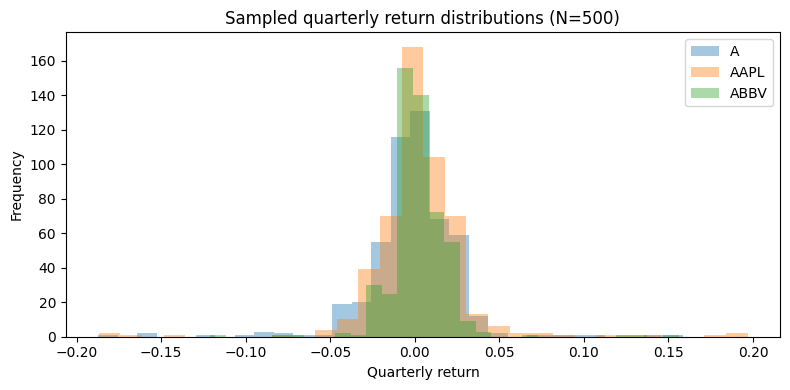

In [34]:
# ---------------------------- 7. Quick run on `train_data` -------------------
# 下面的示例代码依赖用户在当前 Python 环境中已经拥有名为 `train_data` 的
# pandas.DataFrame（如截图所示），且列顺序满足 <TICKER>_open,close,high,low。
# 直接复制到脚本末尾即可运行；不会影响上面任何类/函数定义。

if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # 1. 准备 DataFrame -------------------------------------------------------
    try:
        df = train_data.copy()
    except NameError:
        raise RuntimeError("请先在当前解释器中定义 'train_data' DataFrame 再运行脚本！")

    # 2. 提取股票代码列表 -----------------------------------------------------
    tickers = sorted({col.split("_")[0] for col in df.columns})
    print(f"Detected {len(tickers)} tickers: {tickers[:10]}{'...' if len(tickers)>10 else ''}")

    # 3. 构造数据集 / DataLoader --------------------------------------------
    tau = 63  # 一个季度
    dataset = AllHistoryDataset(df, tickers, tau=tau, stride=7)
    loader  = DataLoader(dataset, batch_size=1, shuffle=True)

    # 4. 初始化并训练 BRAVE ---------------------------------------------------
    brave = BRAVETrainer(tickers, tau=tau, model_dim=128, latent_dim=64, device="cpu")
    brave.train_teacher(loader, epochs=30)
    brave.train_student(loader, epochs=10)

    # 5. 采样未来场景 ---------------------------------------------------------
    past_latest, _ = dataset[-1]
    scenarios = brave.sample_scenarios(past_latest, N=500)  # (N, m)

    # 6. 可视化：前 3 只股票的季度收益分布 ------------------------------
    fig, ax = plt.subplots(figsize=(8, 4))
    for i, tk in enumerate(tickers[:3]):
        ax.hist(scenarios[:, i], bins=30, alpha=0.4, label=tk)
    ax.set_title("Sampled quarterly return distributions (N=500)")
    ax.set_xlabel("Quarterly return")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.tight_layout()
    plt.show()


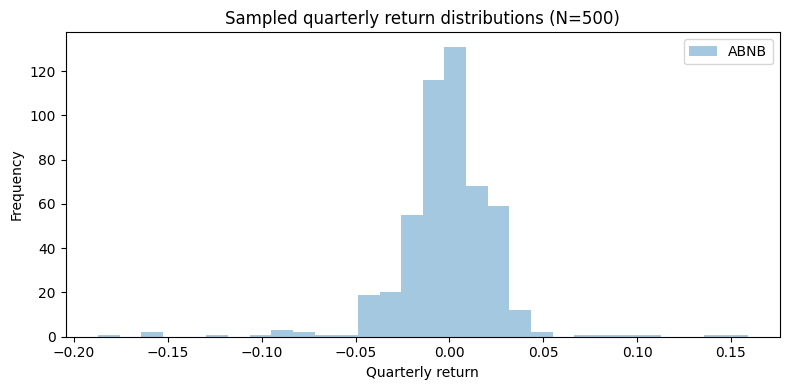

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
for i, tk in enumerate(tickers[3:]):
    ax.hist(scenarios[:, i], bins=30, alpha=0.4, label=tk)
ax.set_title("Sampled quarterly return distributions (N=500)")
ax.set_xlabel("Quarterly return")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()

torch.Size([889, 4, 4])
torch.Size([63, 4])


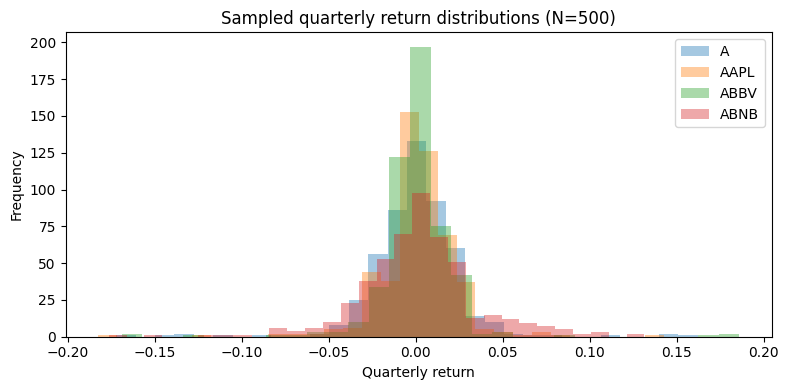

In [147]:
# 5. 采样未来场景 ---------------------------------------------------------
past_latest, future_latest = dataset[-1]
print(past_latest.shape)
print(future_latest.shape)
#print(type(dataset))
scenarios = brave.sample_scenarios(past_latest, N=500)  # (N, m)

# 6. 可视化：前 3 只股票的季度收益分布 ------------------------------
fig, ax = plt.subplots(figsize=(8, 4))
for i, tk in enumerate(tickers[:4]):
    ax.hist(scenarios[:, i], bins=30, alpha=0.4, label=tk)
ax.set_title("Sampled quarterly return distributions (N=500)")
ax.set_xlabel("Quarterly return")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()

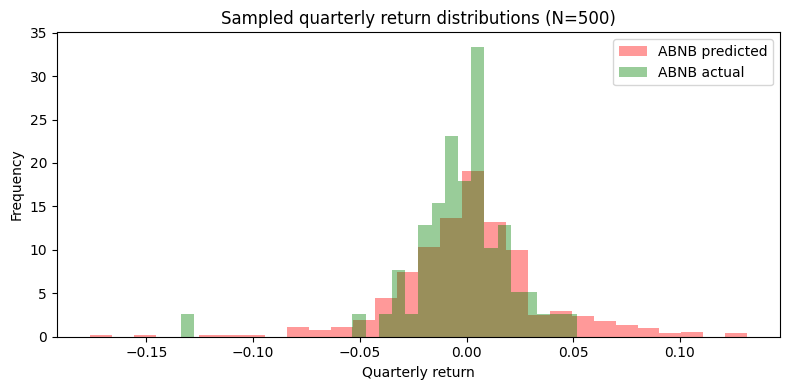

In [148]:
# ABNB预测出的收益率分布和对应时间段的真实分布,将柱状图归一化为概率密度图
abnb = df["ABNB_close"].pct_change().dropna().values
abnb = abnb[~np.isnan(abnb)]
abnb = abnb[abnb > -0.2]
abnb = abnb[abnb < 0.2]
abnb = abnb[-63:]
#abnb = abnb[:len(scenarios)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(scenarios[:, 3], bins=30, alpha=0.4, label="ABNB predicted", density=True, color="red")
ax.hist(abnb, bins=30, alpha=0.4, label="ABNB actual", density=True, color="green")
ax.set_title("Sampled quarterly return distributions (N=500)")
ax.set_xlabel("Quarterly return")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()

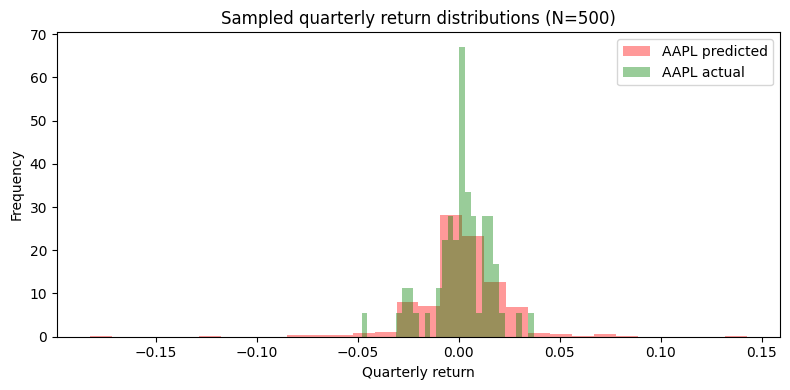

In [149]:
# APPL预测出的收益率分布和对应时间段的真实分布
appl = df["AAPL_close"].pct_change().dropna().values
appl = appl[~np.isnan(appl)]
appl = appl[appl > -0.2]
appl = appl[appl < 0.2]
appl = appl[-63:]
appl = appl[:len(scenarios)]
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(scenarios[:, 1], bins=30, alpha=0.4, label="AAPL predicted", density=True, color="red")
ax.hist(appl, bins=30, alpha=0.4, label="AAPL actual", density=True, color="green")
ax.set_title("Sampled quarterly return distributions (N=500)")
ax.set_xlabel("Quarterly return")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()

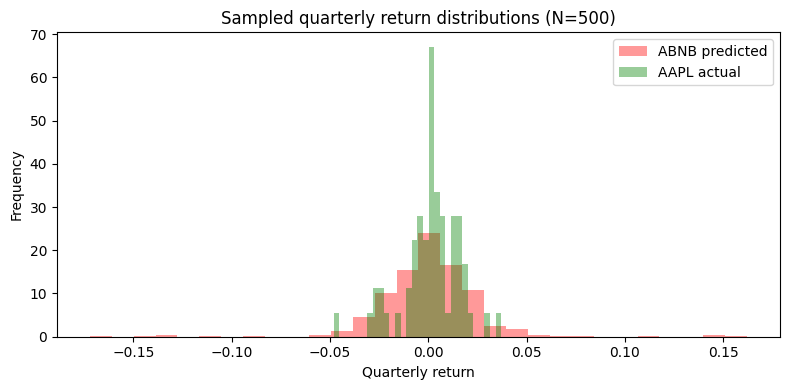

In [151]:
# ABNB predicted和AAPL actual的收益率分布对比
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(scenarios[:, 0], bins=30, alpha=0.4, label="ABNB predicted", density=True, color="red")
ax.hist(appl, bins=30, alpha=0.4, label="AAPL actual", density=True, color="green")
ax.set_title("Sampled quarterly return distributions (N=500)")
ax.set_xlabel("Quarterly return")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()